# Recommender Systems 2021/2022

## Practice - Hybrid Recommenders

### There are several strategies you can adopt to create hybrid models
* Stacking URM, ICM, UCM
* Combine already available models all with the same model structure
* Combine already available models with different model structure
* Combine already available models with rating prediction vs ranking loss functions
* User-wise discrimination

## Some basic information about hybrid models

### The way to go to achieve the best recommendation quality
In order to create an effective hybrid model you need a few things:
* Reasonably well performing models
* Models must look at the task in (at least slightly) different ways
* It must be possible to combine the two

There are many different types of hybrids, we will be covering only some of them.


### In Movielens10M we have the usual URM, but also several ICMs

In [1]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Data_manager.Movielens.Movielens10MReader import Movielens10MReader

data_reader = Movielens10MReader()
data_loaded = data_reader.load_data()

URM_all = data_loaded.get_URM_all()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.8)

Movielens10M: Verifying data consistency...
Movielens10M: Verifying data consistency... Passed!
DataReader: current dataset is: Movielens10M
	Number of items: 10681
	Number of users: 69878
	Number of interactions in URM_all: 10000054
	Value range in URM_all: 0.50-5.00
	Interaction density: 1.34E-02
	Interactions per user:
		 Min: 2.00E+01
		 Avg: 1.43E+02
		 Max: 7.36E+03
	Interactions per item:
		 Min: 0.00E+00
		 Avg: 9.36E+02
		 Max: 3.49E+04
	Gini Index: 0.57

	ICM name: ICM_tags, Value range: 1.00 / 69.00, Num features: 10106, feature occurrences: 106820, density 9.90E-04
	ICM name: ICM_genres, Value range: 1.00 / 1.00, Num features: 20, feature occurrences: 21564, density 1.01E-01
	ICM name: ICM_all, Value range: 1.00 / 69.00, Num features: 10126, feature occurrences: 128384, density 1.19E-03
	ICM name: ICM_year, Value range: 1.92E+03 / 2.01E+03, Num features: 1, feature occurrences: 10681, density 1.00E+00




In [2]:
from Evaluation.Evaluator import EvaluatorHoldout

cutoff_list=[5, 10, 15]

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=cutoff_list)
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=cutoff_list)

EvaluatorHoldout: Ignoring 273 ( 0.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 71 ( 0.1%) Users that have less than 1 test interactions


# Stacking

A simple idea is to look at both iteractions and features as a similar type of information. Given an item, you can see the users that interacted with it as *features* of that item, in the same way as its genre.

To do so, you can concatenate URM and ICM in a single data structure of shape |n_users + n_features|x|n_items|

WARNING: You are creating a new matrix that can be used as URM or ICM interchangeably and plugged into any model you already have. This gives you flexibility but requires caution, for example, what happens if you use that stacked URM in a UserBasedKNN vs in an ItemBasedKNN? (hint: only in one it makes sense)

In [3]:
import scipy.sparse as sps

ICM_genres = data_loaded.get_loaded_ICM_dict()["ICM_genres"]

stacked_URM = sps.vstack([URM_train, ICM_genres.T])
stacked_URM = sps.csr_matrix(stacked_URM)

stacked_ICM = sps.csr_matrix(stacked_URM.T)

stacked_URM, stacked_ICM

(<69898x10681 sparse matrix of type '<class 'numpy.float64'>'
 	with 6421598 stored elements in Compressed Sparse Row format>,
 <10681x69898 sparse matrix of type '<class 'numpy.float64'>'
 	with 6421598 stored elements in Compressed Sparse Row format>)

At this point you can use it to train any model you have. Suggestions:
* If one of the two is much larger than the other (like in this case, 60k users vs 20 features) the smaller will be overwhelmed numerically. Add a weight to the smaller one to increase its importance (will only work for models that allow explicit interactions, will not work with models that use implicit ones)
* If the ICM has a bad recommendation quality, maybe stacking will not help
* When computing a item-based similarity, you can also use only *some* of the features or users. This is called feature selection and is a wide area of research.

In [4]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

recommender_ItemKNNCF = ItemKNNCFRecommender(stacked_URM)
recommender_ItemKNNCF.fit()

result_df, _ = evaluator_validation.evaluateRecommender(recommender_ItemKNNCF)
result_df

Similarity column 10681 (100.0%), 2312.01 column/sec. Elapsed time 4.62 sec
EvaluatorHoldout: Processed 69605 (100.0%) in 27.62 sec. Users per second: 2520


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.215056,0.225291,0.090872,0.138229,0.143827,0.389422,0.172658,0.127759,0.630199,0.521047,...,0.996093,0.627737,0.996093,0.02122,8.016964,0.993392,0.10758,0.706954,1.699859,0.045304
10,0.190611,0.237645,0.154553,0.100236,0.121221,0.407714,0.190355,0.170698,0.764428,0.629396,...,0.996093,0.761441,0.996093,0.024756,8.291142,0.995078,0.125505,0.731132,1.618601,0.091362
15,0.17355,0.262661,0.204577,0.08158,0.116895,0.41226,0.206596,0.187791,0.821521,0.683948,...,0.996093,0.818312,0.996093,0.027482,8.471118,0.995899,0.139328,0.747003,1.561104,0.137909


In [5]:
recommender_ItemKNNCBF = ItemKNNCBFRecommender(URM_train, stacked_ICM)
recommender_ItemKNNCBF.fit()

result_df, _ = evaluator_validation.evaluateRecommender(recommender_ItemKNNCBF)
result_df

ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 2284.50 column/sec. Elapsed time 4.68 sec
EvaluatorHoldout: Processed 69605 (100.0%) in 27.35 sec. Users per second: 2545


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.215056,0.225291,0.090872,0.138229,0.143827,0.389422,0.172658,0.127759,0.630199,0.521047,...,0.996093,0.627737,0.996093,0.02122,8.016964,0.993396,0.108939,0.707859,1.699676,0.045481
10,0.190611,0.237645,0.154553,0.100236,0.121221,0.407714,0.190355,0.170698,0.764428,0.629396,...,0.996093,0.761441,0.996093,0.024756,8.291142,0.995083,0.12709,0.732067,1.618405,0.09172
15,0.17355,0.262661,0.204577,0.08158,0.116895,0.41226,0.206596,0.187791,0.821521,0.683948,...,0.996093,0.818312,0.996093,0.027482,8.471118,0.995904,0.141088,0.747958,1.560902,0.13845


The framework already includes a model that does stacking, but only applied to the KNNs

In [6]:
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender

recommender_ItemKNNCFCBF = ItemKNN_CFCBF_Hybrid_Recommender(URM_train, ICM_genres)
recommender_ItemKNNCFCBF.fit(ICM_weight = 10.0)

result_df, _ = evaluator_validation.evaluateRecommender(recommender_ItemKNNCFCBF)
result_df

ItemKNN_CFCBF_HybridRecommender: URM Detected 62 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 2408.78 column/sec. Elapsed time 4.43 sec
EvaluatorHoldout: Processed 69605 (100.0%) in 27.09 sec. Users per second: 2570


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.215548,0.225782,0.09103,0.138662,0.144266,0.39012,0.173025,0.128002,0.631032,0.522393,...,0.996093,0.628567,0.996093,0.021311,8.026952,0.993441,0.109407,0.708741,1.696602,0.045506
10,0.190935,0.237934,0.154648,0.100506,0.121494,0.40835,0.19077,0.170886,0.764931,0.63077,...,0.996093,0.761942,0.996093,0.024614,8.293007,0.995104,0.126364,0.732232,1.61686,0.091739
15,0.173806,0.2629,0.204703,0.081785,0.117119,0.412904,0.20706,0.187994,0.822197,0.685375,...,0.996093,0.818985,0.996093,0.027169,8.467266,0.995915,0.139479,0.747618,1.560471,0.138443


# Hybrid of models with the same structure

The underlying idea is that if you have some models with the same underlying structure, you can merge them in a single one. The result is to define a function that give the various model's parameters creates a new model with its own parameters.
In this example we will see how to combine different item-item similarity models in a new one.

In particular: `ItemKNNCFRecommender` and `P3AlphaRecommender`. Both use and learn a similarity matrix to provide recommendations. Notice that here we are merging a KNN-based with a Graph-based model.


In [7]:
itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit()

ItemKNNCFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 2333.71 column/sec. Elapsed time 4.58 sec


In [8]:
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender

P3alpha = P3alphaRecommender(URM_train)
P3alpha.fit()

P3alphaRecommender: URM Detected 62 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity column 10681 (100.0%), 2225.97 column/sec. Elapsed time 4.80 sec


Now that we have both models fit with `URM_train` how can we merge them?


Well, we could take the advantage that they have the same underlying structure, i.e. a similarity matrix

In [9]:
itemKNNCF.W_sparse

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 530778 stored elements in Compressed Sparse Row format>

In [10]:
P3alpha.W_sparse

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 198573 stored elements in Compressed Sparse Row format>

When we create hybrids we always have to account for:
* A weight, which is a hyperparameter to tune. 
* What is the range and distribution of the values we are merging

Imagine that the values of one similarity are orders of magnitude higher than the other, then the smaller values would get absorbed by the bigger ones. 

In [11]:
alpha = 0.7
new_similarity = (1 - alpha) * itemKNNCF.W_sparse + alpha * P3alpha.W_sparse
new_similarity

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 709908 stored elements in Compressed Sparse Row format>

Moreover, we can apply the same optimizations to this similarity as we applied to the others (for example: topK neighbors)

The framework includes a recommender class which supports a custom similarity

In [12]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

recommender_object = ItemKNNCustomSimilarityRecommender(URM_train)
recommender_object.fit(new_similarity)

result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
result_df

ItemKNNCustomSimilarityRecommender: URM Detected 62 ( 0.6%) items with no interactions.
EvaluatorHoldout: Processed 69605 (100.0%) in 27.76 sec. Users per second: 2507


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.216961,0.227371,0.092207,0.139733,0.145533,0.392961,0.175445,0.129414,0.634078,0.526223,...,0.996093,0.631601,0.996093,0.020214,7.924737,0.992703,0.103772,0.699716,1.746697,0.045294
10,0.19187,0.239707,0.156371,0.101204,0.12276,0.411078,0.193298,0.172311,0.767201,0.634988,...,0.996093,0.764203,0.996093,0.023793,8.220823,0.994687,0.122148,0.725859,1.657244,0.091393
15,0.174487,0.264849,0.206691,0.082346,0.118515,0.415557,0.209542,0.189228,0.823375,0.689672,...,0.996093,0.820158,0.996093,0.026548,8.410109,0.995616,0.13629,0.742572,1.594439,0.138005


### Analysis of similarities

Now that we have seen how to build a hybrid like this, let's see how different are the different similarities matrices built by each recommender (CBF, CF, and CFCBF).

ItemKNNCFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 2299.55 column/sec. Elapsed time 4.64 sec
ItemKNNCBFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
Compute_Similarity: detected dense matrix
Similarity column 10681 (100.0%), 9185.24 column/sec. Elapsed time 1.16 sec
ItemKNN_CFCBF_HybridRecommender: URM Detected 62 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 2309.82 column/sec. Elapsed time 4.62 sec


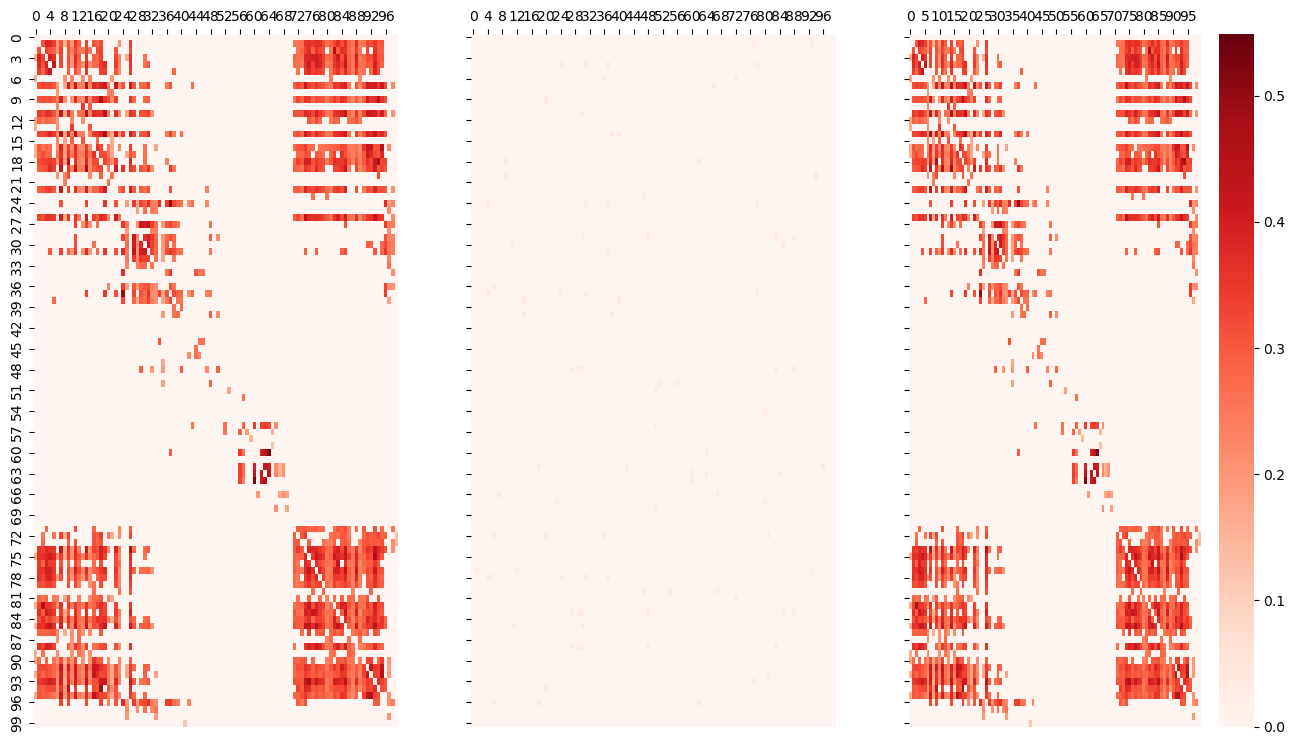

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


recommender_ItemKNNCF = ItemKNNCFRecommender(URM_train)
recommender_ItemKNNCF.fit()

recommender_ItemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM_genres)
recommender_ItemKNNCBF.fit()

recommender_ItemKNNCFCBF = ItemKNN_CFCBF_Hybrid_Recommender(URM_train, ICM_genres)
recommender_ItemKNNCFCBF.fit()

cf_sim = recommender_ItemKNNCF.W_sparse
cbf_sim = recommender_ItemKNNCBF.W_sparse
cfcbf_sim = recommender_ItemKNNCFCBF.W_sparse

cf_sim_max = cf_sim.max()
cbf_sim_max = cbf_sim.max()
cfcbf_sim_max = cfcbf_sim.max()
vmax = np.max([cf_sim_max, cbf_sim_max, cfcbf_sim_max])

f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.heatmap(cf_sim[:100, :100].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax1, cmap="Reds")
sns.heatmap(cbf_sim[:100, :100].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax2, cmap="Reds")
sns.heatmap(cfcbf_sim[:100, :100].todense(), cbar=True, vmin=0, vmax=vmax, ax=ax3, cmap="Reds")
ax1.xaxis.set_ticks_position("top")
ax2.xaxis.set_ticks_position("top")
ax3.xaxis.set_ticks_position("top")

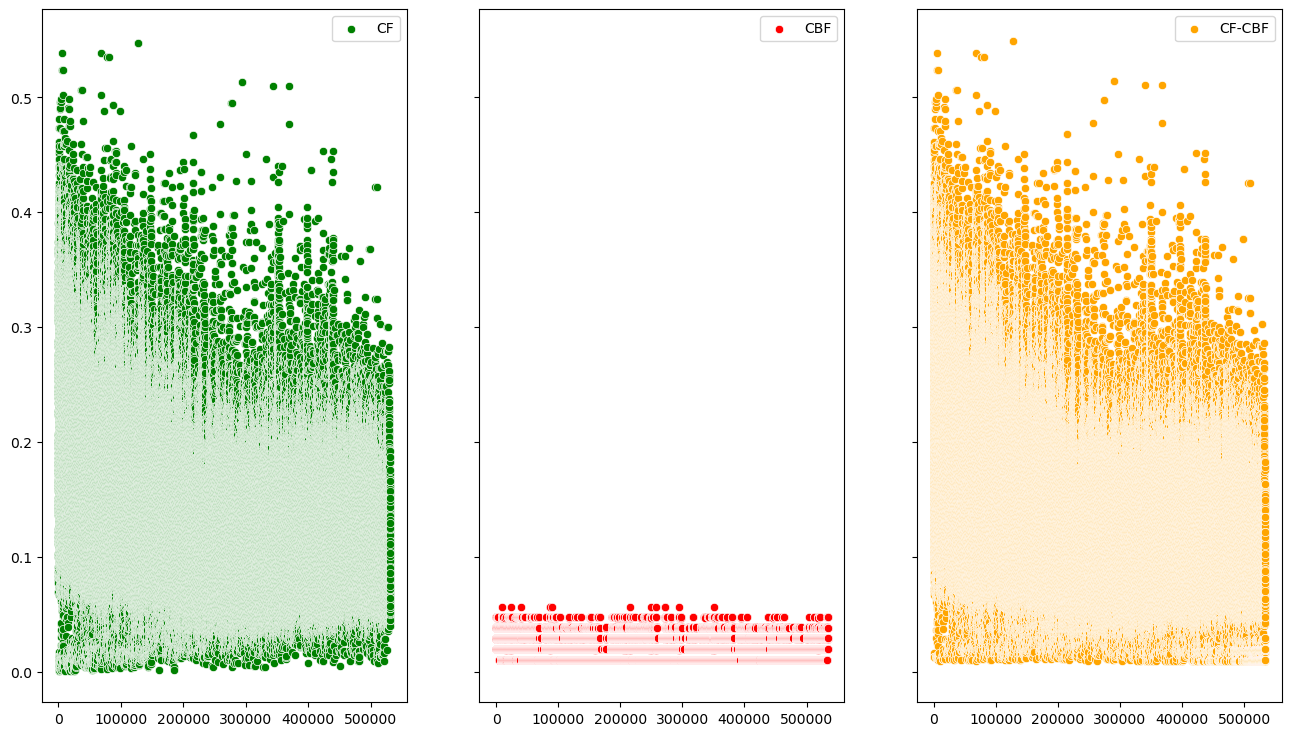

In [14]:
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.scatterplot(data=cf_sim.data, ax=ax1, color="green")
sns.scatterplot(data=cbf_sim.data, ax=ax2, color="red")
sns.scatterplot(data=cfcbf_sim.data, ax=ax3, color="orange")
ax1.legend(["CF"])
ax2.legend(["CBF"])
ax3.legend(["CF-CBF"])

/opt/homebrew/Caskroom/miniconda/base/envs/RSFramework/lib/python3.9/site-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/homebrew/Caskroom/miniconda/base/envs/RSFramework/lib/python3.9/site-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/homebrew/Caskroom/miniconda/base/envs/RSFramework/lib/python3.9/site-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


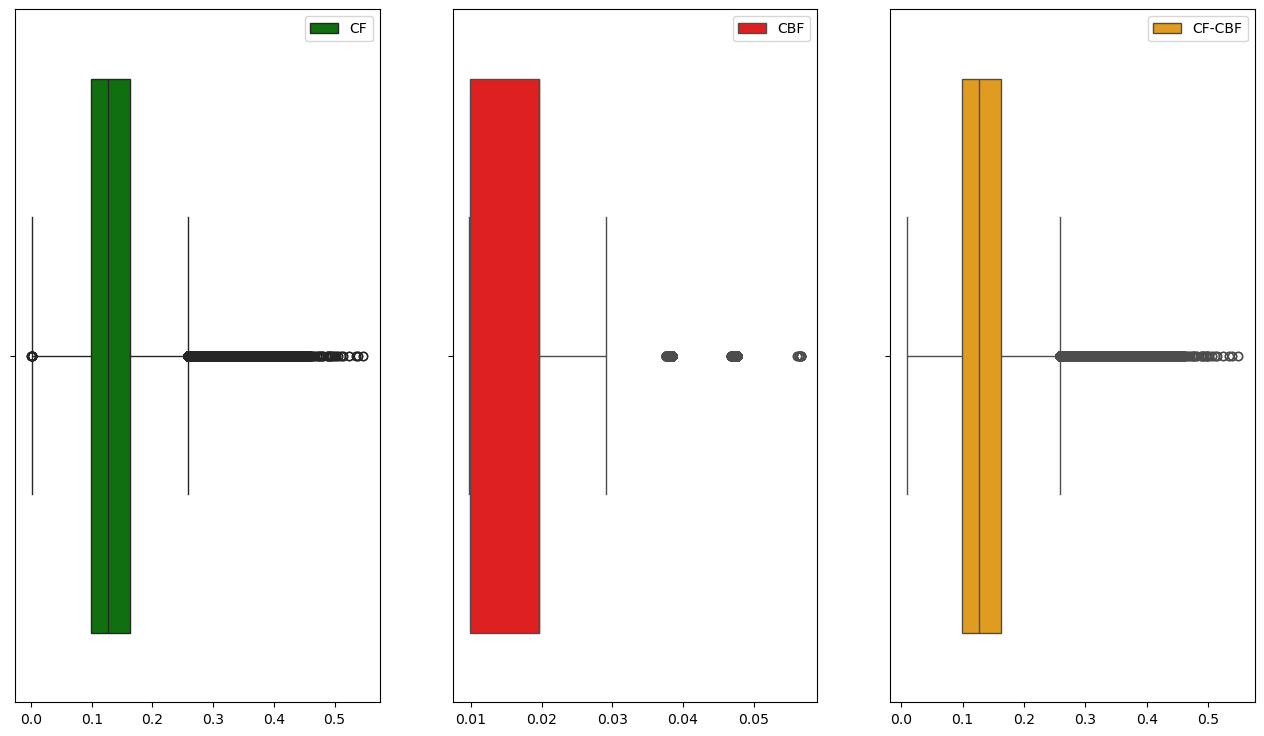

In [15]:
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.boxplot(x=cf_sim.data, orient="v", ax=ax1, color="green")
sns.boxplot(x=cbf_sim.data, orient="v", ax=ax2, color="red")
sns.boxplot(x=cfcbf_sim.data, orient="v", ax=ax3, color="orange")
ax1.legend(["CF"])
ax2.legend(["CBF"])
ax3.legend(["CF-CBF"])

# Hybrid of models with different structure

We just saw the case where models had compatible structure (ItemKNN with P3Alpha) but there are certain cases where we want to combine recommenders with different underlying structures. For instance ItemKNN and UserKNN or ItemKNN with PureSVD.

In this case we cannot combine the model parameters themselves, rather we can combine the *predictions*.

In [16]:
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender

pureSVD = PureSVDRecommender(URM_train)
pureSVD.fit()

PureSVDRecommender: URM Detected 62 ( 0.6%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 3.73 sec


We can combine the predictions via a weighted average

In [17]:
user_id = 50

item_scores_itemknn = itemKNNCF._compute_item_score(user_id)
item_scores_itemknn

array([[ 0.62778383, 14.416438  , 13.350765  , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [18]:
item_scores_puresvd = pureSVD._compute_item_score(user_id)
item_scores_puresvd

array([-0.03119744,  1.5582134 ,  1.3156058 , ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

As you can see, we provide a score for every item in the dataset in both recommenders. 

Remember that after calculating these scores, we sort them and take the n-most relevant ones.

Again we use a weight

In [19]:
alpha = 0.7

new_item_scores = alpha * item_scores_itemknn + (1 - alpha) * item_scores_puresvd
new_item_scores

array([[ 0.43008944, 10.558971  ,  9.740217  , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

Now we create a recommeder class. Note that again we can build a hybrid combining any number of models

In [20]:
from Recommenders.BaseRecommender import BaseRecommender

class ScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1*alpha + R2*(1-alpha)

    """

    RECOMMENDER_NAME = "ScoresHybridRecommender"

    def __init__(self, URM_train, recommender_1, recommender_2):
        super(ScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        
        
    def fit(self, alpha = 0.5):
        self.alpha = alpha      


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        # In a simple extension this could be a loop over a list of pretrained recommender objects
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        item_weights = item_weights_1*self.alpha + item_weights_2*(1-self.alpha)

        return item_weights

In [21]:
scoreshybridrecommender = ScoresHybridRecommender(URM_train, itemKNNCF, pureSVD)
scoreshybridrecommender.fit(alpha = 0.5)

result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
result_df

ScoresHybridRecommender: URM Detected 62 ( 0.6%) items with no interactions.
EvaluatorHoldout: Processed 69605 (100.0%) in 28.11 sec. Users per second: 2476


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.216961,0.227371,0.092207,0.139733,0.145533,0.392961,0.175445,0.129414,0.634078,0.526223,...,0.996093,0.631601,0.996093,0.020214,7.924737,0.992703,0.103772,0.699716,1.746697,0.045294
10,0.19187,0.239707,0.156371,0.101204,0.12276,0.411078,0.193298,0.172311,0.767201,0.634988,...,0.996093,0.764203,0.996093,0.023793,8.220823,0.994687,0.122148,0.725859,1.657244,0.091393
15,0.174487,0.264849,0.206691,0.082346,0.118515,0.415557,0.209542,0.189228,0.823375,0.689672,...,0.996093,0.820158,0.996093,0.026548,8.410109,0.995616,0.13629,0.742572,1.594439,0.138005


# Models with rating prediction vs ranking loss functions

Sometimes we have models that optimize different loss functions, one BPR (ranking) and another rating prediction (MSE). For instance:
- SLIMBPR and SLIM EN/MSE
- MF and MFBPR
- ...

This brings another important problem, for rank-based models there is no clear meaning for the *absolute value* of the prediction. A value of 15.245 may be low or high, depending on the *other* values.

In those cases it becomes essential to include a *normalization* on the weights, to ensure that the values are, at least, in the same range for all models. Many normalizations can be used: min/max, l1, l2, other nonlinear functions (sigmoid, ...)


In [22]:
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_SVDpp_Cython

svd_recommender = MatrixFactorization_SVDpp_Cython(URM_train)
svd_recommender.fit(epochs=200)

MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 62 ( 0.6%) items with no interactions.
SVD++: Processed 6401000 (100.0%) in 3.10 sec. MSE loss 2.16E+00. Sample per second: 2062191
SVD++: Epoch 1 of 200. Elapsed time 2.50 sec
SVD++: Processed 6401000 (100.0%) in 2.70 sec. MSE loss 1.13E+00. Sample per second: 2373415
SVD++: Epoch 2 of 200. Elapsed time 5.09 sec
SVD++: Processed 6401000 (100.0%) in 3.01 sec. MSE loss 1.13E+00. Sample per second: 2126192
SVD++: Epoch 3 of 200. Elapsed time 7.41 sec
SVD++: Processed 6401000 (100.0%) in 2.31 sec. MSE loss 1.13E+00. Sample per second: 2769930
SVD++: Epoch 4 of 200. Elapsed time 9.71 sec
SVD++: Processed 6401000 (100.0%) in 2.59 sec. MSE loss 1.12E+00. Sample per second: 2467331
SVD++: Epoch 5 of 200. Elapsed time 11.99 sec
SVD++: Processed 6401000 (100.0%) in 3.16 sec. MSE loss 1.12E+00. Sample per second: 2028554
SVD++: Epoch 6 of 200. Elapsed time 14.55 sec
SVD++: Processed 6401000 (100.0%) in 2.48 sec. MSE loss 1.12E+00. Sample

In [23]:
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython

slim_bpr_recommender = SLIM_BPR_Cython(URM_train)
slim_bpr_recommender.fit(epochs=200)

SLIM_BPR_Recommender: URM Detected 62 ( 0.6%) items with no interactions.


/bin/sh: free: command not found


Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 69878 (100.0%) in 0.32 sec. BPR loss is 3.73E-04. Sample per second: 221451
SLIM_BPR_Recommender: Epoch 1 of 200. Elapsed time 0.16 sec
Processed 69878 (100.0%) in 0.48 sec. BPR loss is 1.19E-03. Sample per second: 144714
SLIM_BPR_Recommender: Epoch 2 of 200. Elapsed time 0.33 sec
Processed 69878 (100.0%) in 0.65 sec. BPR loss is 2.02E-03. Sample per second: 107634
SLIM_BPR_Recommender: Epoch 3 of 200. Elapsed time 0.50 sec
Processed 69878 (100.0%) in 0.81 sec. BPR loss is 2.88E-03. Sample per second: 85767
SLIM_BPR_Recommender: Epoch 4 of 200. Elapsed time 0.66 sec
Processed 69878 (100.0%) in 0.98 sec. BPR loss is 3.69E-03. Sample per second: 71202
SLIM_BPR_Recommender: Epoch 5 of 200. Elapsed time 0.83 sec
Processed 69878 (100.0%) in 1.15 sec. BPR loss is 4.

Both of these recommenders have the `_compute_item_score` function. However, the scores might be totally different.

Let's see

In [24]:
svd_score = svd_recommender._compute_item_score(user_id)
svd_score

array([3.36250128, 3.32608816, 2.9218492 , ..., 3.57127466, 3.51937523,
       3.5276656 ])

In [25]:
slim_bpr_score = slim_bpr_recommender._compute_item_score(user_id).flatten()
slim_bpr_score

array([0.02872567, 1.1371342 , 1.171804  , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

Here is where things get complicated. You see, the scores that each function computes have completely different meanings, we cannot just join them as if they are the same thing. 

Let's calculate some percentiles and do some visualizations on the scores.

In [26]:
import seaborn as sns
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

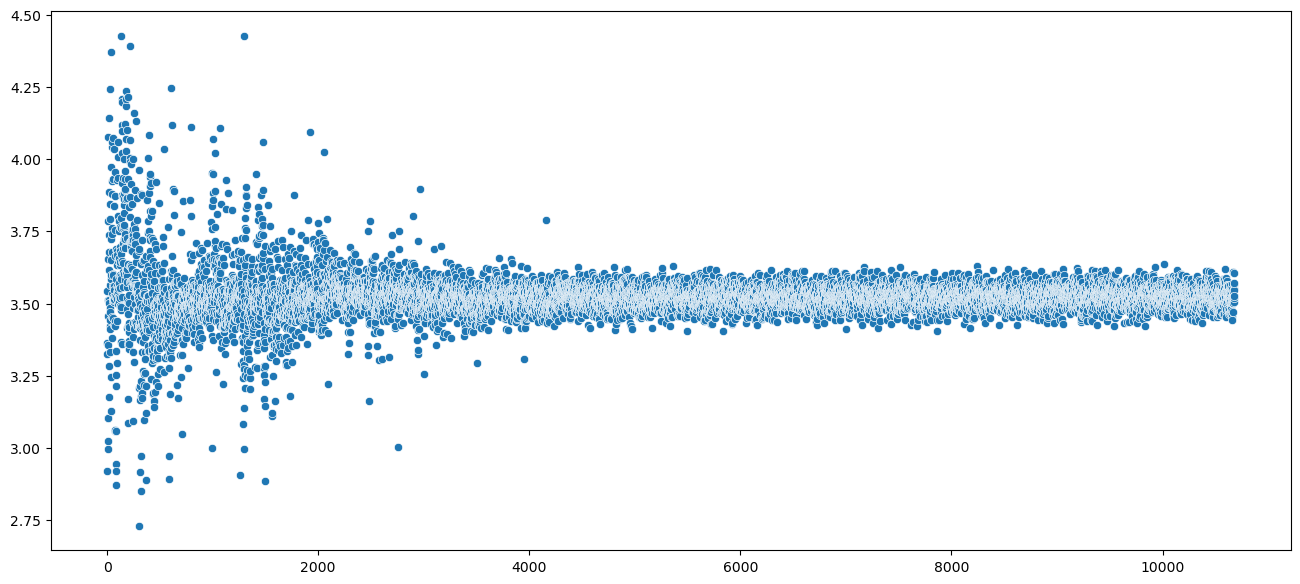

In [27]:
_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=svd_score)

In [28]:
np.percentile(svd_score, [0, 25, 50, 75, 100])


array([2.73043956, 3.49536875, 3.52347558, 3.55039388, 4.42797043])

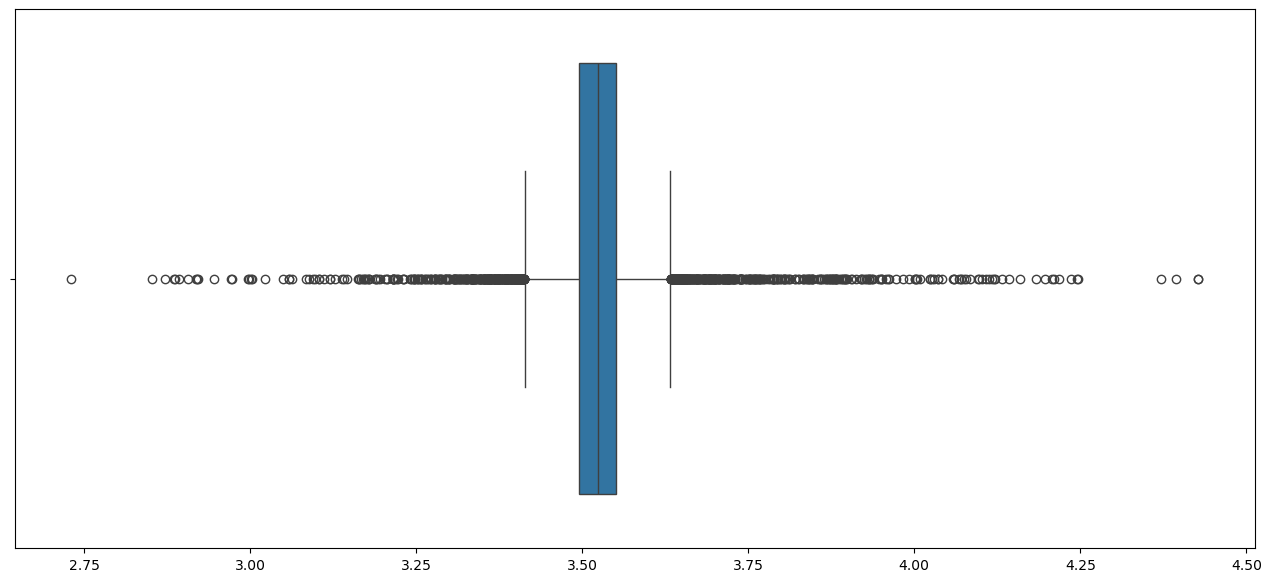

In [29]:
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=svd_score)

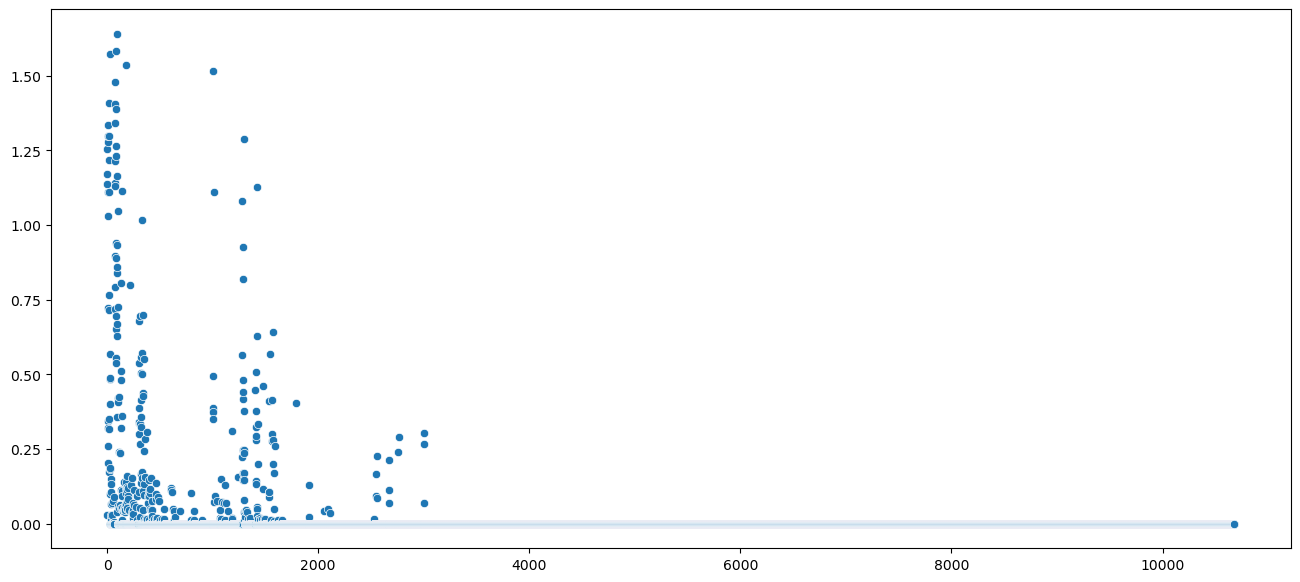

In [30]:
_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=slim_bpr_score)

In [31]:
np.percentile(slim_bpr_score, [0, 25, 50, 75, 100])


array([0.        , 0.        , 0.        , 0.        , 1.64006758])

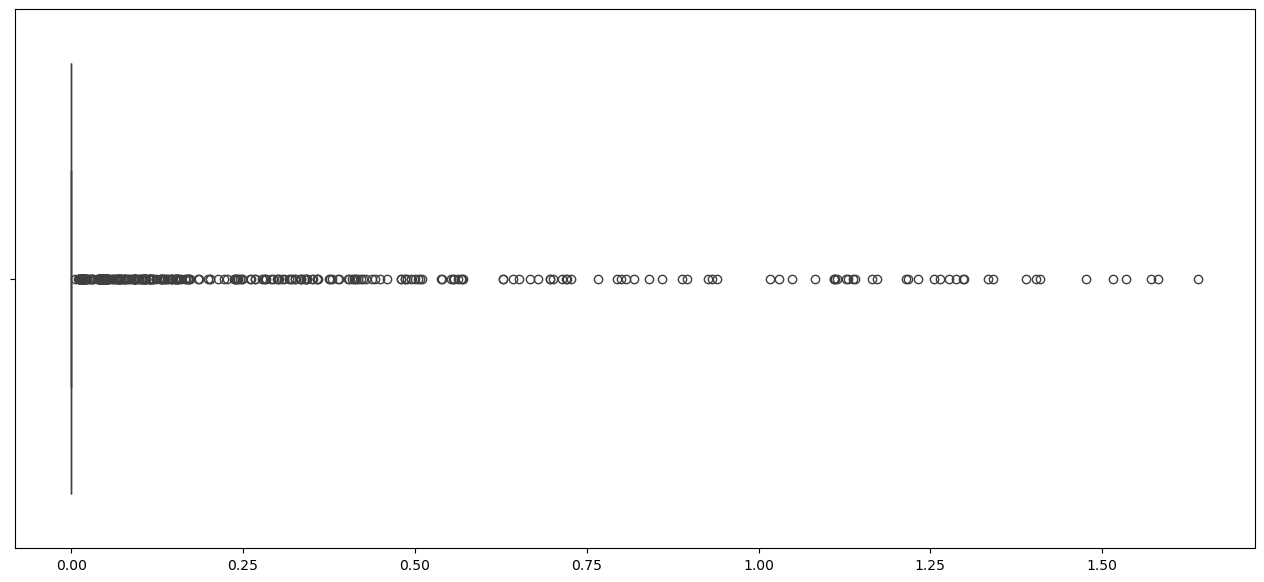

In [32]:
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=slim_bpr_score)

As you can see from the plots and the percentiles, the values held in each score array is totally different from one to another. 

As such, we need a way to _normalize_ these scores to be able to merge them into one.

[3.36250128 3.32608816 2.9218492  ... 3.57127466 3.51937523 3.5276656 ] 4.427970434137074 364.39984130251725 4.427970434137074 2.7304395639717525


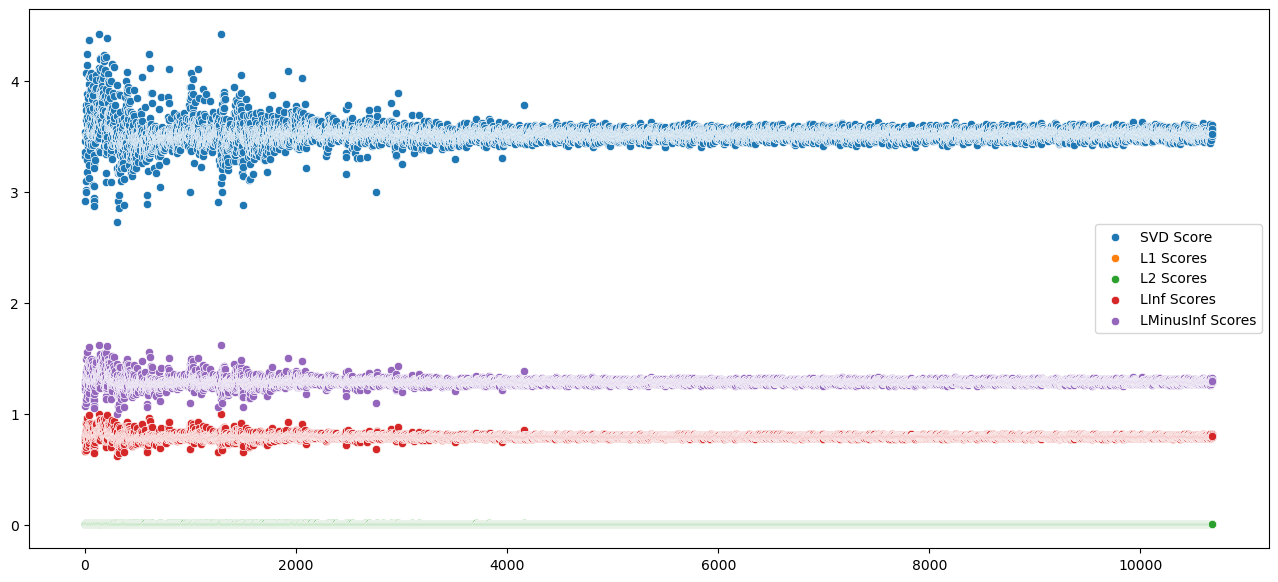

In [33]:
l1_svd = LA.norm([svd_score], 1)
l1_svd_scores = svd_score / l1_svd

l2_svd = LA.norm([svd_score], 2)
l2_svd_scores = svd_score / l2_svd

linf_svd = LA.norm(svd_score, np.inf)
linf_svd_scores = svd_score / linf_svd

lminusinf_svd = LA.norm(svd_score, -np.inf)
lminusinf_svd_scores = svd_score / lminusinf_svd

print(svd_score, l1_svd, l2_svd, linf_svd, lminusinf_svd)

_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=svd_score)
ax = sns.scatterplot(data=l1_svd_scores) 
ax = sns.scatterplot(data=l2_svd_scores) 
ax = sns.scatterplot(data=linf_svd_scores) 
ax = sns.scatterplot(data=lminusinf_svd_scores) 
ax.legend(["SVD Score", "L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

Similarly, we can do the same with SLIM BPR scores

[0.02872567 1.1371342  1.171804   ... 0.         0.         0.        ] 106.576355 9.1734085 1.6400676 0.0


/var/folders/pp/q0kl1bl507q_7gsf1tczbrg80000gn/T/ipykernel_39302/4109638917.py:11: RuntimeWarning: divide by zero encountered in divide
  lminusinf_slim_bpr_scores = slim_bpr_score / lminusinf_slim_bpr
/var/folders/pp/q0kl1bl507q_7gsf1tczbrg80000gn/T/ipykernel_39302/4109638917.py:11: RuntimeWarning: invalid value encountered in divide
  lminusinf_slim_bpr_scores = slim_bpr_score / lminusinf_slim_bpr


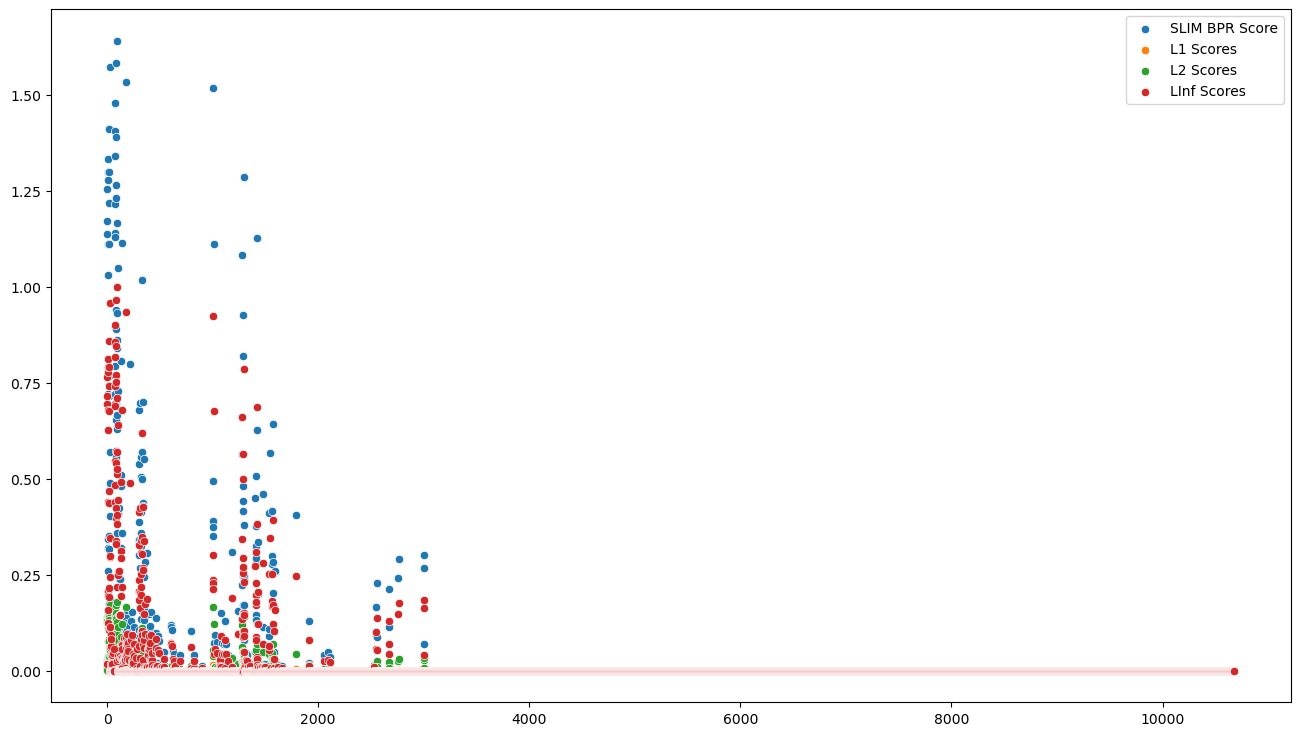

In [34]:
l1_slim_bpr = LA.norm(slim_bpr_score, 1)
l1_slim_bpr_scores = slim_bpr_score / l1_slim_bpr

l2_slim_bpr = LA.norm(slim_bpr_score, 2)
l2_slim_bpr_scores = slim_bpr_score / l2_slim_bpr

linf_slim_bpr = LA.norm(slim_bpr_score, np.inf)
linf_slim_bpr_scores = slim_bpr_score / linf_slim_bpr

lminusinf_slim_bpr = LA.norm(slim_bpr_score, -np.inf)
lminusinf_slim_bpr_scores = slim_bpr_score / lminusinf_slim_bpr

print(slim_bpr_score, l1_slim_bpr, l2_slim_bpr, linf_slim_bpr, lminusinf_slim_bpr)

_ = plt.figure(figsize=(16,9))
ax = sns.scatterplot(data=slim_bpr_score)
ax = sns.scatterplot(data=l1_slim_bpr_scores) 
ax = sns.scatterplot(data=l2_slim_bpr_scores) 
ax = sns.scatterplot(data=linf_slim_bpr_scores) 
ax = sns.scatterplot(data=lminusinf_slim_bpr_scores) 
ax.legend(["SLIM BPR Score", "L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

Now that we have *normalized* the different item score vectors, we can merge the models.

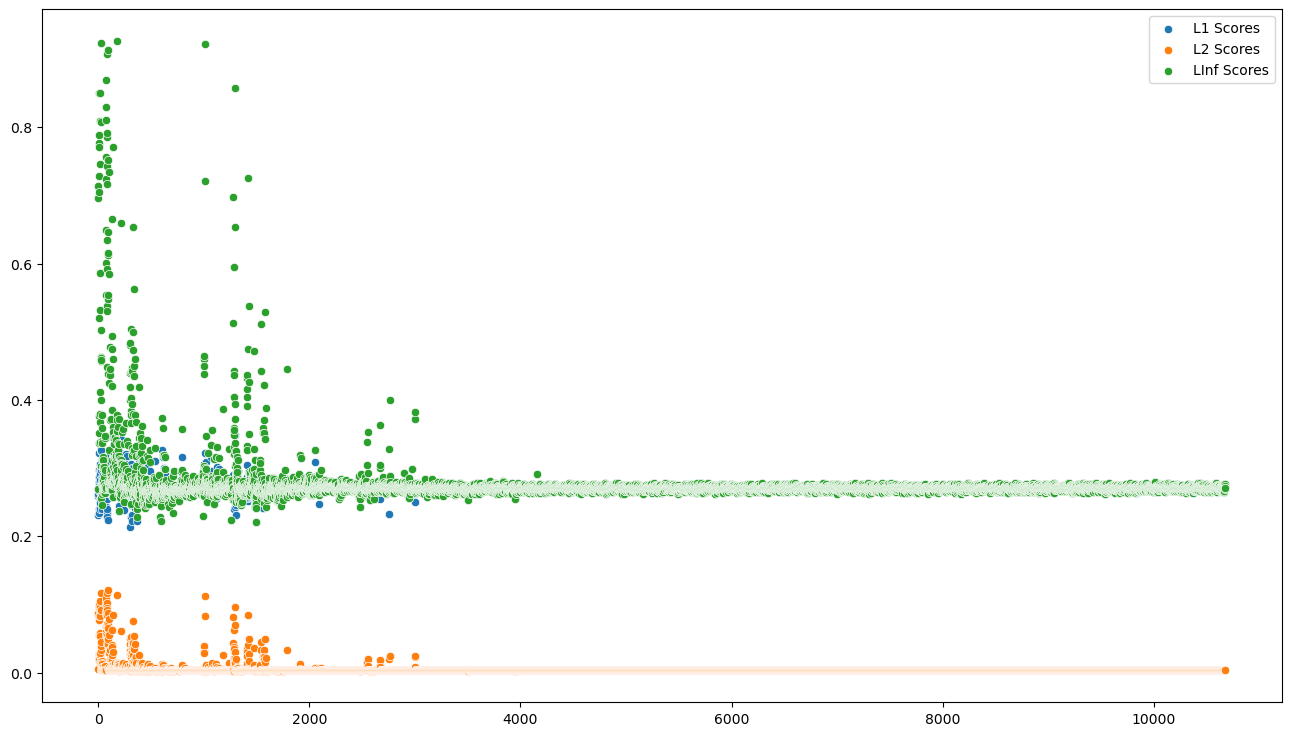

In [35]:
lambda_weights = 0.66

l1_new_scores = lambda_weights * l1_slim_bpr_scores + (1 - lambda_weights) * l1_svd_scores
l2_new_scores = lambda_weights * l2_slim_bpr_scores + (1 - lambda_weights) * l2_svd_scores
linf_new_scores = lambda_weights * linf_slim_bpr_scores + (1 - lambda_weights) * linf_svd_scores
lminusinf_new_scores = lambda_weights * lminusinf_slim_bpr_scores + (1 - lambda_weights) * lminusinf_svd_scores

_ = plt.figure(figsize=(16,9))
ax = sns.scatterplot(data=l1_new_scores)
ax = sns.scatterplot(data=l2_new_scores) 
ax = sns.scatterplot(data=linf_new_scores) 
ax = sns.scatterplot(data=lminusinf_new_scores) 
ax.legend(["L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

Now, we have everything to create our hybrid.

In [36]:
class DifferentLossScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1/norm*alpha + R2/norm*(1-alpha) where R1 and R2 come from
    algorithms trained on different loss functions.

    """

    RECOMMENDER_NAME = "DifferentLossScoresHybridRecommender"


    def __init__(self, URM_train, recommender_1, recommender_2):
        super(DifferentLossScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        
        
        
    def fit(self, norm, alpha = 0.5):

        self.alpha = alpha
        self.norm = norm


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        norm_item_weights_1 = LA.norm(item_weights_1, self.norm)
        norm_item_weights_2 = LA.norm(item_weights_2, self.norm)
        
        
        if norm_item_weights_1 == 0:
            raise ValueError("Norm {} of item weights for recommender 1 is zero. Avoiding division by zero".format(self.norm))
        
        if norm_item_weights_2 == 0:
            raise ValueError("Norm {} of item weights for recommender 2 is zero. Avoiding division by zero".format(self.norm))
        
        item_weights = item_weights_1 / norm_item_weights_1 * self.alpha + item_weights_2 / norm_item_weights_2 * (1-self.alpha)

        return item_weights



In [37]:
recommender_object = DifferentLossScoresHybridRecommender(URM_train, svd_recommender, slim_bpr_recommender)

for norm in [1, 2, np.inf, -np.inf]:

    recommender_object.fit(norm, alpha = 0.66)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
    print("Norm: {}, Result: {}".format(norm, result_df.loc[10]["MAP"]))

DifferentLossScoresHybridRecommender: URM Detected 62 ( 0.6%) items with no interactions.
EvaluatorHoldout: Processed 69605 (100.0%) in 38.91 sec. Users per second: 1789
Norm: 1, Result: 0.07862746644045245
EvaluatorHoldout: Processed 69605 (100.0%) in 4.19 min. Users per second: 277
Norm: 2, Result: 0.08881316510514146
EvaluatorHoldout: Processed 69605 (100.0%) in 39.57 sec. Users per second: 1759
Norm: inf, Result: 0.08899671559355535
EvaluatorHoldout: Processed 69605 (100.0%) in 38.87 sec. Users per second: 1791
Norm: -inf, Result: 0.08944451912892472


## Important note:

You can build a hybrid with any number of techniques and models, be advised however that optimizing them is difficult.
* If you use already trained and optimized models and try to combine them you have a weight per each model and possibly a normalization. If you put together 10 models it will be difficult for the optimizer to find good hyperparameters due to a number of problems, for example the noise introduced by the lower performing algorithms;
* If you decide to try to optimize both the hybrid hyperparameters and each single model hyperparameters all at once, you end up with hundreds of hyperparameters to optimize. In theory you could be able to find a better result, in practice you will likely not.
* Some strategies can be used to minimize this, for example some smart initial points you provide to the optimizer... Maybe you start from all the hyperparameter configurations of the single models taken independently that you have already optimized, you use them as initialization points for the optimizer and then you try to *further* optimize them as part of the hybrid. (may be complicated, result is not guaranteed) 

A good solution is to proceed incrementally. For example:
* Start with the best model and set a weight and normalization, let's say 1.0 and l1;
* Add the second-best model and try to create a hybrid of the two optimizing only weight and normalization of the model you are trying to add;
* Once the optimization concludes, check if the hybrid is better than before or not. If it is better keep the new hybrid, if not remove the second-best model.
* Continue trying to add the third-best, fourth-best and so on...
* If you are lucky every now and then a new model can be added and the quality improves. (again, result not guaranteed)


Alternatively you can combine the model predictions with more complex strategies, for example with XGBoost. This is usually the go-to approach for hybrids that we use in the international challenges but goes beyond the scope of this course.

# Some tricks, user-wise hybrids

Models do not have the same accuracy for different user types. Let's divide the users according to their profile length and then compare the recommendation quality we get from a CF model.

Let's categorize user based on the number of interactions they have.

In [38]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
profile_length, profile_length.shape

(array([18, 10, 24, ..., 92, 30, 38], dtype=int32), (69878,))

Let's select a few groups of 5% of the users with the least number of interactions.

In [39]:
block_size = int(len(profile_length)*0.05)
block_size

3493

In [40]:
sorted_users = np.argsort(profile_length)
sorted_users

array([47927, 50557, 58278, ..., 14085, 65888, 57959])

In [41]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    

Group 0, #users in group 3493, average p.len 11.77, median 12.0, min 6, max 13
Group 1, #users in group 3493, average p.len 14.56, median 15.0, min 13, max 16
Group 2, #users in group 3493, average p.len 16.61, median 17.0, min 16, max 18
Group 3, #users in group 3493, average p.len 18.84, median 19.0, min 18, max 20
Group 4, #users in group 3493, average p.len 21.32, median 21.0, min 20, max 23
Group 5, #users in group 3493, average p.len 24.25, median 24.0, min 23, max 26
Group 6, #users in group 3493, average p.len 27.59, median 28.0, min 26, max 29
Group 7, #users in group 3493, average p.len 31.50, median 31.0, min 29, max 34
Group 8, #users in group 3493, average p.len 35.97, median 36.0, min 34, max 38
Group 9, #users in group 3493, average p.len 41.32, median 41.0, min 38, max 44
Group 10, #users in group 3493, average p.len 47.64, median 48.0, min 44, max 51
Group 11, #users in group 3493, average p.len 55.72, median 56.0, min 51, max 60
Group 12, #users in group 3493, average

Now let's calculate the evaluation metrics of each recommender when considering groups of users.

In [44]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_SVDpp_Cython, MatrixFactorization_AsySVD_Cython
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "PureSVD": PureSVDRecommender,
                                   # "NMF": NMFRecommender,
                                   "SVD": MatrixFactorization_SVDpp_Cython,
                                   "SLIMBPR": SLIM_BPR_Cython,
                                   }

content_recommender_class = {"ItemKNNCBF": ItemKNNCBFRecommender,
                             "ItemKNNCFCBF": ItemKNN_CFCBF_Hybrid_Recommender
                            }

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train)
    recommender_object.fit()
    recommender_object_dict[label] = recommender_object

for label, recommender_class in content_recommender_class.items():
    recommender_object = recommender_class(URM_train, ICM_genres)
    recommender_object.fit()
    recommender_object_dict[label] = recommender_object



TopPopRecommender: URM Detected 62 ( 0.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
Similarity column 69878 (100.0%), 618.22 column/sec. Elapsed time 1.88 min
ItemKNNCFRecommender: URM Detected 62 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 2401.19 column/sec. Elapsed time 4.45 sec
P3alphaRecommender: URM Detected 62 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity column 10681 (100.0%), 2242.62 column/sec. Elapsed time 4.76 sec
RP3betaRecommender: URM Detected 62 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 10681 (100.0%), 2156.87 column/sec. Elapsed time 4.95 sec
PureSVDRecommender: URM Detected 62 ( 0.6%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 3.03 sec
MatrixFactorization_SVDpp_Cython_Recommender: URM Detected 62 ( 0.6%) items with no interactions.
SVD++

/bin/sh: free: command not found


Processed 69878 (100.0%) in 0.44 sec. BPR loss is 3.70E-04. Sample per second: 157975
SLIM_BPR_Recommender: Epoch 1 of 300. Elapsed time 0.16 sec
Processed 69878 (100.0%) in 0.61 sec. BPR loss is 1.19E-03. Sample per second: 114853
SLIM_BPR_Recommender: Epoch 2 of 300. Elapsed time 0.33 sec
Processed 69878 (100.0%) in 0.77 sec. BPR loss is 2.02E-03. Sample per second: 90163
SLIM_BPR_Recommender: Epoch 3 of 300. Elapsed time 0.50 sec
Processed 69878 (100.0%) in 0.94 sec. BPR loss is 2.85E-03. Sample per second: 74144
SLIM_BPR_Recommender: Epoch 4 of 300. Elapsed time 0.66 sec
Processed 69878 (100.0%) in 1.11 sec. BPR loss is 3.63E-03. Sample per second: 62992
SLIM_BPR_Recommender: Epoch 5 of 300. Elapsed time 0.83 sec
Processed 69878 (100.0%) in 0.27 sec. BPR loss is 4.52E-03. Sample per second: 255440
SLIM_BPR_Recommender: Epoch 6 of 300. Elapsed time 0.99 sec
Processed 69878 (100.0%) in 0.44 sec. BPR loss is 5.40E-03. Sample per second: 159154
SLIM_BPR_Recommender: Epoch 7 of 300. Ela

In [45]:
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
        

Group 0, #users in group 3493, average p.len 11.77, median 12.0, min 6, max 13
EvaluatorHoldout: Ignoring 71 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 66385 Users
EvaluatorHoldout: Processed 3493 (100.0%) in 1.26 sec. Users per second: 2775
EvaluatorHoldout: Processed 3493 (100.0%) in 1.24 sec. Users per second: 2824
EvaluatorHoldout: Processed 3493 (100.0%) in 1.36 sec. Users per second: 2567
EvaluatorHoldout: Processed 3493 (100.0%) in 1.28 sec. Users per second: 2719
EvaluatorHoldout: Processed 3493 (100.0%) in 1.27 sec. Users per second: 2752
EvaluatorHoldout: Processed 3493 (100.0%) in 1.79 sec. Users per second: 1947
EvaluatorHoldout: Processed 3493 (100.0%) in 1.91 sec. Users per second: 1828
EvaluatorHoldout: Processed 3493 (100.0%) in 1.38 sec. Users per second: 2539
EvaluatorHoldout: Processed 3493 (100.0%) in 1.31 sec. Users per second: 2662
EvaluatorHoldout: Processed 3493 (100.0%) in 1.27 sec. Users per second: 2748
Group 1, #users in

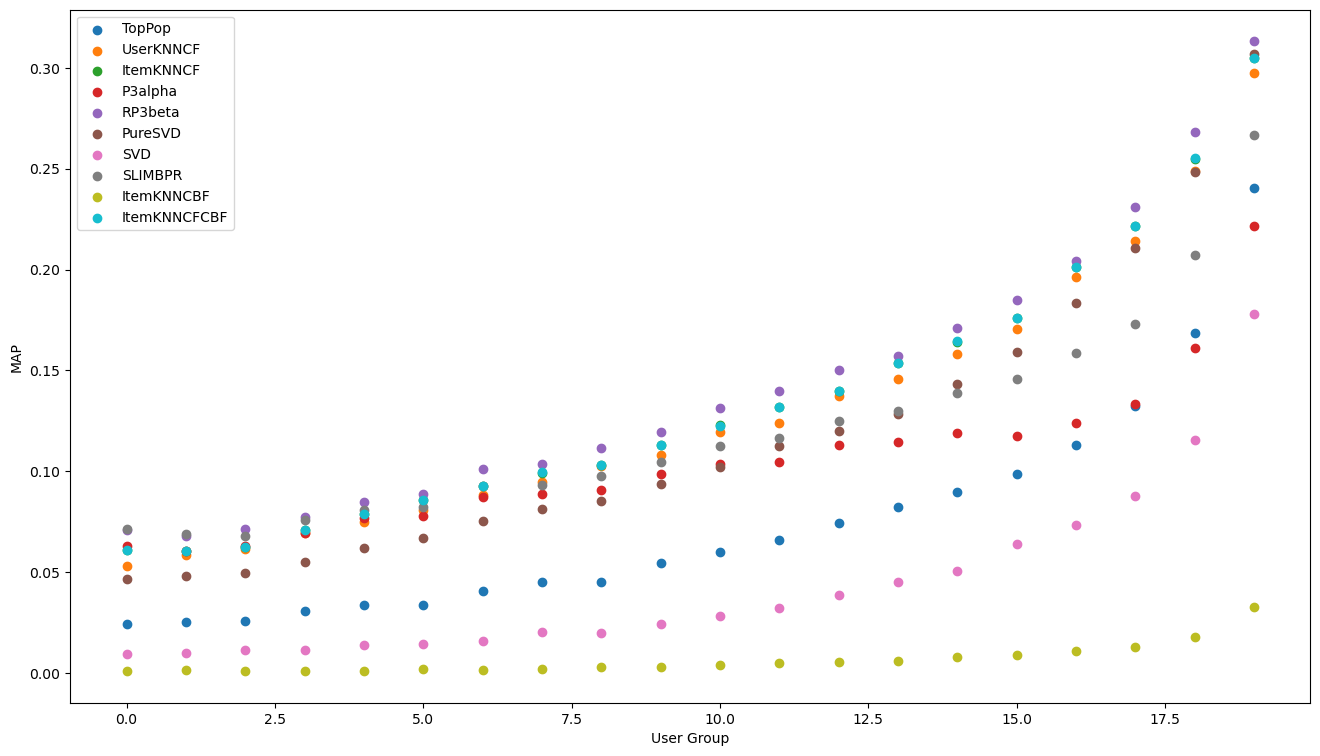

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

### The recommendation quality of the three algorithms changes depending on the user profile length

## Tip:
### If an algorithm works best on average, it does not imply it will work best for ALL user types